# Data Visualization and Result Analysis for Chapter 2

___
### Tested Models

* LBBD
    * MIP Tool Packing --> CP Autoclave Packing <--> CP Scheduling
* CP Full Packing + CP Scheduling
* MIP Full Packing + CP Scheduling
* EDD Full Packing + CP Scheduling

### Instance Sizes

* 100
* 300
* 500

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
# Load instances
result_data = {}
print('loading...')
for i in [200, 0, 1, 2, 3]:
    temp = {}
    for j in [100, 300, 500]:
        filepath = f'../archive/chap_2/instances_031820_{i}/jobs_{j}/summary.xlsx'
        if i == 200:
            temp[j] = [pd.read_excel(filepath, 'rsp')]
        elif i == 0:
            temp[j] = [pd.read_excel(filepath, 'current_exp')]
        else:
            temp[j] = [pd.read_excel(filepath, 'current_exp_pack'),
                       pd.read_excel(filepath, 'current_exp_sched')]
    result_data[i] = temp
    print(f'results loaded for model type {i}')

loading...
results loaded for model type 200
results loaded for model type 0
results loaded for model type 1
results loaded for model type 2
results loaded for model type 3


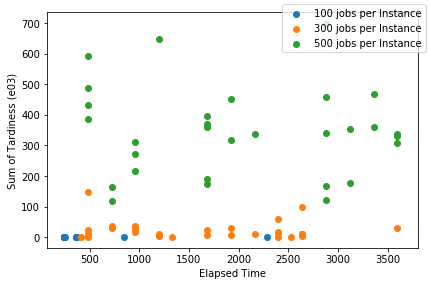

In [3]:
# Type 0 result summary
fig, ax = plt.subplots()
for key in result_data[0].keys():
    tardiness = []
    elapsed_time = []
    for i in range(0, 30):
        elapsed_time.append(result_data[0][key][0]['elapsed_time_to_best'][i])
        tardiness.append(result_data[0][key][0]['tardiness'][i])
    ax.scatter(elapsed_time, [tardiness[j] / 1000 for j in range(30)],
               label=f'{key} jobs per Instance')
ax.set_xlabel('Elapsed Time')
ax.set_ylabel('Sum of Tardiness (e03)')
fig.legend()
fig.tight_layout()
plt.show()

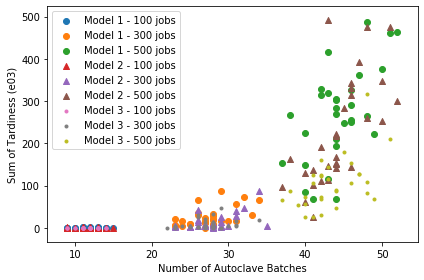

In [4]:
# Type 1, 2, 3 result summary
fig, ax = plt.subplots()
params = ['o', '^', '.']
for k, model in enumerate([1, 2, 3]):
    for key in result_data[model].keys():
        tardiness = []
        numbins = []
        for i in range(0, 30):
            numbins.append(result_data[model][key][0]['numbins'][i])
            tardiness.append(result_data[model][key][1]['tardiness'][i])
        ax.scatter(numbins,
                   [tardiness[j] / 1000 for j in range(30)],
                   marker=params[k], label=f'Model {model} - {key} jobs')
ax.set_xlabel('Number of Autoclave Batches')
ax.set_ylabel('Sum of Tardiness (e03)')
ax.legend()
fig.tight_layout()
plt.show()

Coefficient a: 2.898970661596621
Coefficient b: 1.100750991393714
Coefficient c: -15.378453198790782
R^2 value: 0.7303556758954914


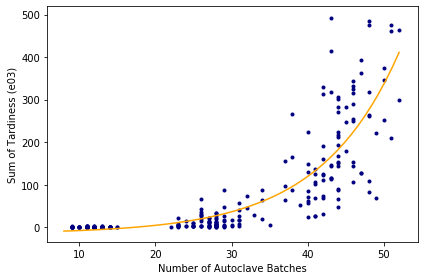

In [5]:
# Fitting an exponential function to the bin vs tardiness graph above
# First define exponential function
def exp(x, a, b, c):
    return a * (b ** x) + c

# Get data points
x_values = []
y_values = []
for model in [1, 2, 3]:
    for key in result_data[model].keys():
        for i in range(0, 30):
            x_values.append(result_data[model][key][0]['numbins'][i])
            y_values.append(result_data[model][key][1]['tardiness'][i] / 1000)

# Fit curve
param, param_cov = curve_fit(exp, x_values, y_values)
SS_res = np.sum([(y_values[i] - exp(x_values[i],
                                    param[0],
                                    param[1],
                                    param[2])) ** 2
                 for i in range(len(x_values))])
SS_tot = np.sum([(y_values[i] - np.mean(y_values)) ** 2
                 for i in range(len(y_values))])
R_2 = 1 - (SS_res / SS_tot)

# Print results
print(f'Coefficient a: {param[0]}')
print(f'Coefficient b: {param[1]}')
print(f'Coefficient c: {param[2]}')
print(f'R^2 value: {R_2}')

# Print data with fitted curve
fitted_x = np.linspace(8, 52, num=50)
fitted_y = [param[0] * (param[1] ** fitted_x[i]) + param[2]
            for i in range(len(fitted_x))]
fig, ax = plt.subplots()
ax.plot(fitted_x, fitted_y, color='orange')
ax.scatter(x_values, y_values, marker='.', color='navy')
ax.set_xlabel('Number of Autoclave Batches')
ax.set_ylabel('Sum of Tardiness (e03)')
fig.tight_layout()
plt.show()

In [ ]:
# Compare job tardiness to RSP distribution


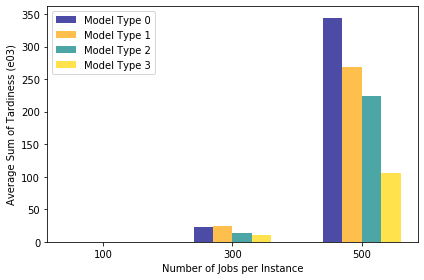

In [45]:
# Compare average tardiness across all models and instance size classes
width = 0.15
x_values = [1, 2, 3]
x_offsets = [-width * 1.5, -width * 0.5, width * 0.5, width * 1.5]
colors = ['navy', 'orange', 'teal', 'gold']
fig, ax = plt.subplots()
for k, model in enumerate([0, 1, 2, 3]):
    tardiness = []
    for key in result_data[model].keys():
        if model == 0:
            tardiness.append(np.mean(result_data[model][key][0]['tardiness']) / 1000)
        else:
            tardiness.append(np.mean(result_data[model][key][1]['tardiness']) / 1000)
    ax.bar([x_values[i] + x_offsets[k] for i in range(3)],
           tardiness, width, label=f'Model Type {model}',
           color=colors[k], alpha=0.7)
ax.set_ylabel('Average Sum of Tardiness (e03)')
ax.set_xlabel('Number of Jobs per Instance')
ax.set_xticks(x_values)
ax.set_xticklabels(['100', '300', '500'])
ax.legend()
fig.tight_layout()
plt.show()

In [10]:
# Compare percentage of tardy jobs across instance class sizes and models
# Get data
percent_tardy = {}
for model in [0, 1, 2, 3]:
    model_tardy = {}
    for key in result_data[model].keys():
        temp = []
        for instance in range(30):
            filepath = f'../archive/chap_2/instances_031820_{model}/jobs_{key}/instance_{instance}.xlsx'
            df = pd.read_excel(filepath, sheet_name='results', usecols='O')
            zeros = np.sum(df == 0)
            nonzeros = len(df.index) - zeros
            temp.append(nonzeros / len(df.index))
        model_tardy[key] = temp
    percent_tardy[model] = model_tardy
    print(f'Model {model} complete.')

Model 0 complete.
Model 1 complete.
Model 2 complete.
Model 3 complete.


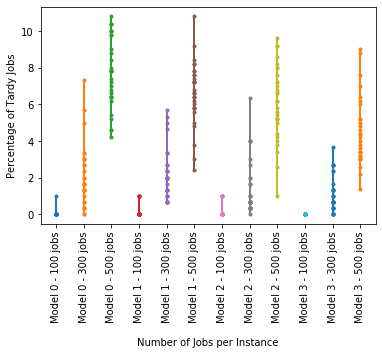

In [46]:
# Plot data
fig, ax = plt.subplots()
x_values = np.linspace(0, 11, 12)
i = 0;
for model in [0, 1, 2, 3]:
    for key in percent_tardy[model].keys():
        ax.plot([x_values[i]] * len(percent_tardy[model][key]),
                [percent_tardy[model][key][i] * 100 for i in range(30)],
                marker='.',
                label=f'Model {model} - {key} jobs')
        i = i + 1
ax.set_xticks(x_values)
ax.set_xticklabels(['Model 0 - 100 jobs',
                    'Model 0 - 300 jobs',
                    'Model 0 - 500 jobs',
                    'Model 1 - 100 jobs',
                    'Model 1 - 300 jobs',
                    'Model 1 - 500 jobs',
                    'Model 2 - 100 jobs',
                    'Model 2 - 300 jobs',
                    'Model 2 - 500 jobs',
                    'Model 3 - 100 jobs',
                    'Model 3 - 300 jobs',
                    'Model 3 - 500 jobs'], rotation='vertical')
ax.set_xlabel('Number of Jobs per Instance', labelpad=15)
ax.set_ylabel('Percentage of Tardy Jobs')
plt.show()